<a href="https://colab.research.google.com/github/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/blob/main/notebooks/00_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fase 1: Análisis Exploratorio de datos

#### **Elección del Conjunto de datos**

In [2]:
import requests
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from io import BytesIO
from statsmodels.tsa.seasonal import seasonal_decompose


In [6]:
# Importar datos
DATA_GITHUB_URL = 'https://raw.githubusercontent.com/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/refs/heads/main/data/power%2Bconsumption%2Bof%2Btetouan%2Bcity/Tetuan%20City%20power%20consumption.csv'

# Descargar los datos desde github
response = requests.get(DATA_GITHUB_URL)

# Convertir en un df desde el xlsx de github
df = pd.read_csv(BytesIO(response.content), sep=',')

# Formato de columnas
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df = df.dropna(subset=['DateTime']) # Eliminar filas con DateTime inválido (NaT)

In [9]:
df.columns

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption'],
      dtype='object')

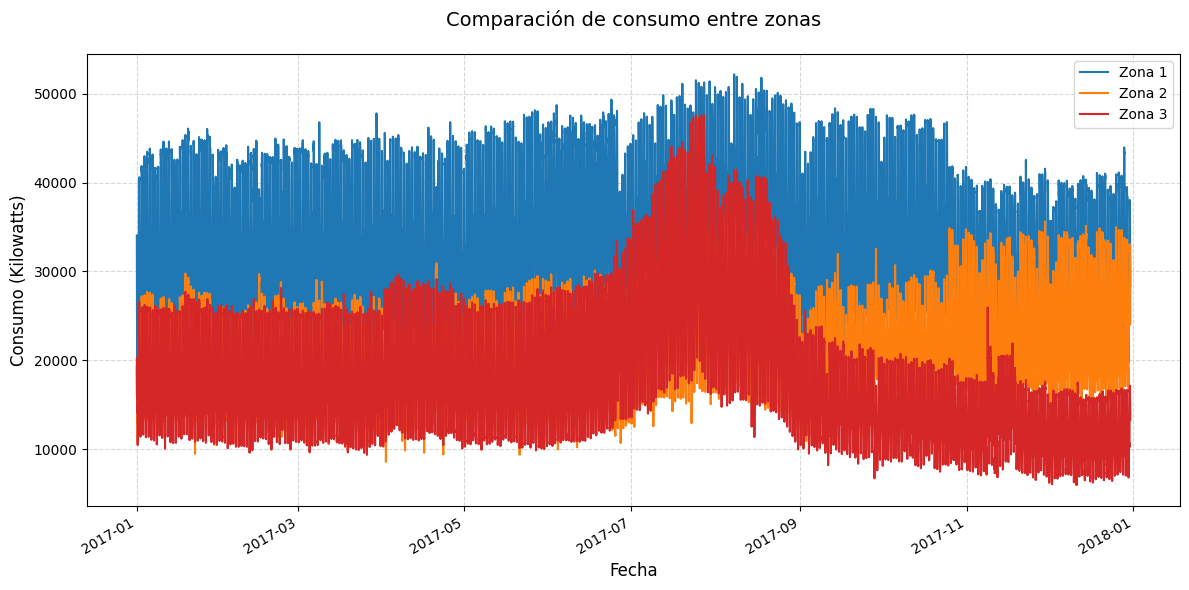

In [12]:
# Análisis de todas las zonas
# Configuración común para gráficos
params = {
    'figure.figsize': (12, 6),
    'axes.titlesize': 14,
    'axes.labelsize': 12,
}
plt.rcParams.update(params)

# --- Gráfico de ambas zonas ---
plt.figure()
plt.plot(df['DateTime'], df['Zone 1 Power Consumption'], color='tab:blue', linewidth=1.5, label='Zona 1')
plt.plot(df['DateTime'], df['Zone 2  Power Consumption'], color='tab:orange', linewidth=1.5, label='Zona 2')
plt.plot(df['DateTime'], df['Zone 3  Power Consumption'], color='tab:red', linewidth=1.5, label='Zona 3')
plt.title('Comparación de consumo entre zonas', pad=20)
plt.xlabel('Fecha')
plt.ylabel('Consumo (Kilowatts)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [ ]:
# Configuración del Dataset
df = df.set_index('DateTime') # Usar la columna DateTime como índice
df = df.sort_index() # Ordenar por fecha
df = df[~df.index.duplicated(keep='first')] # Conservar el primer registro
print("Primer timestamp:", df.index.min())
print("Último timestamp:", df.index.max())
print("Número de observaciones:", df.shape[0])

# Crear un índice regular de 30 minutos
index_regular = pd.date_range(start=df.index.min(), end=df.index.max(), freq='30min')

# Reindexar para forzar frecuencia fija
df_regular = df.reindex(index_regular)

# Interpolar valores faltantes (muy común en mediciones reales)
df_regular = df_regular.interpolate(method='time')

# Confirmar que ya está con frecuencia regular
print("¿Frecuencia regular?:", pd.infer_freq(df_regular.index))

df = df_regular

In [ ]:
### Paso 1: Descomposición de la serie

# Usaremos la función seasonal_decompose de statsmodels, que descompone en:
# - Tendencia
# - Estacionalidad
# - Residuo

# Se selecciona la variable que se quiere analizar (ajusta el nombre)
serie = df_regular['zone1']

# Descomposición estacional
resultado = seasonal_decompose(serie, model='aditive', period=48)
resultado.plot()
plt.suptitle("Descomposición estacional diaria (period=48)", fontsize=16)
plt.tight_layout()
plt.show()

---

#### **Planteamiento de la problemáticas**

---

#### **Analisis de la serie de tiempo**

---

#### **Elección de Variables Exógenas**

---

#### **Elección de Métrica de error**

---